# Introduction

Adventure Works sales data here spans from 5-31-2011 to 5-1-2014; sales data was split test data (15 days) and train data (all days prior to test data). There are 713 stores of which 438 are located in the United States. Other locations include: Canada (115), Australia (40), United Kingdom (40), Germany (40), France (40). Store types are evenly split (~33% per type) between: bicycle manufacturers, bicycle stores, and online stores. Most stores specialize in road cycling (43%), followed by mountain (35%), and touring (22%). We will look at 35 product categories of which road bikes are the most common at 6% of products sold in this time series.

Potential impact: allow forecasting demand of products, guide inventory purchasing decisions, help improve customer satisfaction, prevent lost revenue due to upset customers or insufficient inventory to produce adequate quatities of in demand products.

Credits
* [Kaggle Time Series Course](https://www.kaggle.com/learn/time-series)
* [Machine Learning Strategies for Time Series Forecasting](https://www.researchgate.net/publication/236941795_Machine_Learning_Strategies_for_Time_Series_Forecasting)
* [On the use of cross-validation for time series predictor evaluation](https://doi.org/10.1016/j.ins.2011.12.028)
* [Forecasting Duke University](https://people.duke.edu/~rnau/411home.htm)
* [Georgios Papachristou](https://www.kaggle.com/mscgeorges)

# Prepare

In [17]:
# data loading and transformation tools
import pandas as pd
import numpy as np
import math
from math import sqrt
import calendar
import datetime
from learntools.time_series.style import *
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

# model tools
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split # shuffle false
# from sklearn.multioutput import MultiOutputRegressor # can use with XGB to make out of dataset forecast
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# from scipy.signal import periodogram - import in helper function
# import plotly.express as px
from plotly.subplots import make_subplots
# import plotly.figure_factory as ff
# import plotly.offline as offline
# import plotly.graph_objs as go
%matplotlib inline

# warnings and ignore for ease of reading notebook
import warnings
warnings.filterwarnings("ignore")

# set seed
random_seed = 42

In [18]:
# for visualizing seasonality
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

# for visualizing periodogram - 
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# for multiout model
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

# for creating lag features
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [19]:
# import data
train = pd.read_csv('/kaggle/input/adventureworkstsqlsupplement/train.csv')
test = pd.read_csv('/kaggle/input/adventureworkstsqlsupplement/test.csv')
stores = pd.read_csv('/kaggle/input/adventureworkstsqlsupplement/stores.csv')
transactions = pd.read_csv('/kaggle/input/adventureworkstsqlsupplement/transactions.csv')
holidays = pd.read_csv('/kaggle/input/adventureworkstsqlsupplement/holidays_events.csv')
search = pd.read_csv('/kaggle/input/adventureworkstsqlsupplement/bikewebsearch.csv')
# remove thousands , from sales data and change to float
train['sales'] = train['sales'].str.replace(',', '').astype(float)
test['sales'] = test['sales'].str.replace(',', '').astype(float)
# merge dataframes
full = pd.concat([train, test], sort=True)
# rename duplicate column name
holidays = holidays.rename(columns={'type':'event_type'})
# remove unnecessary columns
events = holidays.loc[:,['date', 'event_type']]
search = search.loc[:,['date', 'total']]
# merge remaining data frames
full = full.merge(stores, how="left", on='storenbr')   
full = full.merge(search, how="left", on='date')      
full = full.merge(transactions, how="left", on=['date','storenbr'])  
full = full.merge(events,on='date',how='left')
full = full.rename(columns={'total':'search_total'})
# check null values
full.isnull().sum()

category             0
date                 0
id                   0
promo                0
sales                0
storenbr             0
city                 0
state                0
country              0
type                 0
cluster              0
search_total    319501
transactions     18032
event_type      267308
dtype: int64

In [20]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354806 entries, 0 to 354805
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   category      354806 non-null  object 
 1   date          354806 non-null  object 
 2   id            354806 non-null  int64  
 3   promo         354806 non-null  float64
 4   sales         354806 non-null  float64
 5   storenbr      354806 non-null  int64  
 6   city          354806 non-null  object 
 7   state         354806 non-null  object 
 8   country       354806 non-null  object 
 9   type          354806 non-null  object 
 10  cluster       354806 non-null  object 
 11  search_total  35305 non-null   float64
 12  transactions  336774 non-null  float64
 13  event_type    87498 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 40.6+ MB


In [21]:
# handle missing values
full['event_type'] = full['event_type'].fillna('none')
full['search_total'] = full['search_total'].fillna(0)
full['transactions'] = full['transactions'].fillna(1)

In [ ]:
# save as csv
full.to_csv('full.csv', index=False)

# Data Overview and Datetime

In [22]:
full.head()

,category,date,id,promo,sales,storenbr,city,state,country,type,cluster,search_total,transactions,event_type
0,Caps,5/31/2011,0,0.0,15.56,298,Mansfield,Ohio,United States,BM,Mountain,0.0,52.0,none
1,Caps,5/31/2011,1,0.0,10.37,308,Kansas City,Missouri,United States,OS,Mountain,0.0,35.0,none
2,Caps,5/31/2011,2,0.0,15.56,306,Leesburg,Virginia,United States,BM,Mountain,0.0,52.0,none
3,Caps,5/31/2011,3,0.0,10.37,296,Branch,Minnesota,United States,BM,Road,0.0,35.0,none
4,Caps,5/31/2011,4,0.0,25.93,292,Memphis,Tennessee,United States,BM,Mountain,0.0,65.0,none


In [23]:
full.describe(include='all')

,category,date,id,promo,sales,storenbr,city,state,country,type,cluster,search_total,transactions,event_type
count,354806,354806,354806.000000,354806.000000,354806.00000,354806.000000,354806,354806,354806,354806,354806,354806.000000,354806.000000,354806
unique,35,1064,NaN,NaN,NaN,NaN,452,65,6,3,3,NaN,NaN,5
top,Jerseys,7/31/2013,NaN,NaN,NaN,NaN,Toronto,California,United States,BM,Road,NaN,NaN,none
freq,22142,18018,NaN,NaN,NaN,NaN,12136,41901,239873,125477,156455,NaN,NaN,267308
mean,NaN,NaN,174469.700281,0.051161,12884.75273,1015.826192,NaN,NaN,NaN,NaN,NaN,10.902786,168.140161,NaN
std,NaN,NaN,100830.518058,0.421820,34559.63230,492.108915,NaN,NaN,NaN,NaN,NaN,33.191824,104.474119,NaN
min,NaN,NaN,0.000000,0.000000,1.37000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN
25%,NaN,NaN,87110.250000,0.000000,165.19000,620.000000,NaN,NaN,NaN,NaN,NaN,0.000000,88.000000,NaN
50%,NaN,NaN,174404.500000,0.000000,750.29000,980.000000,NaN,NaN,NaN,NaN,NaN,0.000000,159.000000,NaN
75%,NaN,NaN,261786.750000,0.000000,4130.98000,1330.000000,NaN,NaN,NaN,NaN,NaN,0.000000,232.000000,NaN


In [24]:
# datetime data types and adding date component columns
full.date = pd.to_datetime(full.date)
#full['year'] = full['date'].dt.year 
full['month'] = full['date'].dt.month
full['week'] = full['date'].dt.weekofyear
full['quarter'] = full['date'].dt.quarter
full['day_of_week'] = full['date'].dt.dayofweek
full['day_of_year'] = full['date'].dt.dayofyear
full['day'] = full['date'].dt.day

# Trend

>> The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year...To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain...Once we've identified the shape of the trend, we can attempt to model it using a time-step feature. We've already seen how using the time dummy itself will model a linear trend: target = a * time + b...We can fit many other kinds of trend through transformations of the time dummy. If the trend appears to be quadratic (a parabola), we just need to add the square of the time dummy to the feature set, giving us: target = a * time ** 2 + b * time + c  Linear regression will learn the coefficients a, b, and c.

Source: Kaggle Time Series Course

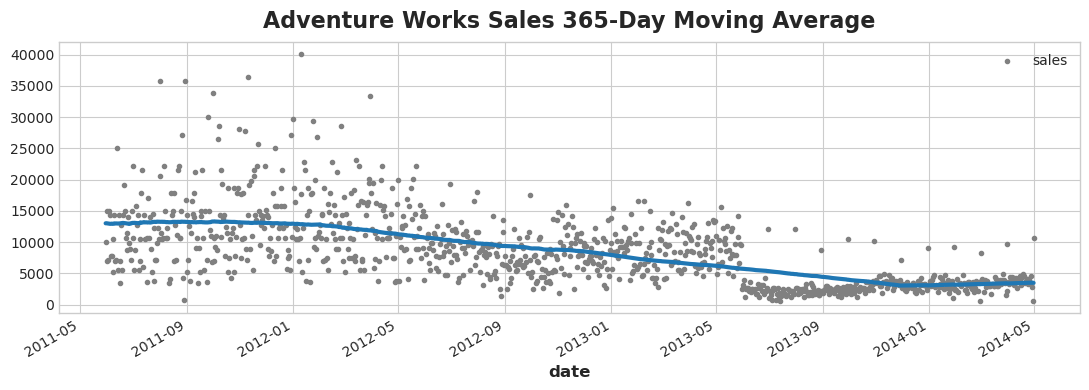

In [25]:
sales = full.groupby('date').agg({"sales" : "mean"}).reset_index()
sales.set_index('date',inplace=True)

moving_average = sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Adventure Works Sales 365-Day Moving Average", legend=False,
);

Sales are decreasing overtime.

Note: these are experiments to look at the sales time series data and its components, not actual evaluation of the model, thus we are not splitting data into training and testing data, just exploring the nature of the data and formulating a plan

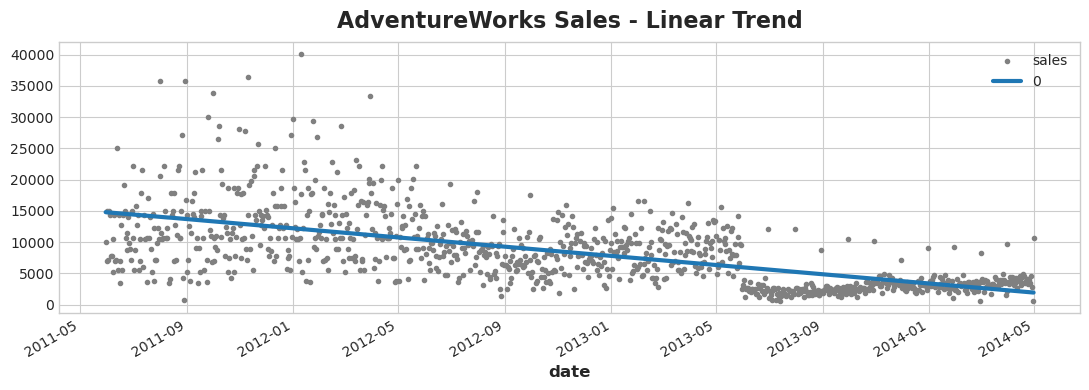

In [26]:
dp = DeterministicProcess(
    index=sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    seasonal = False,    # see seasonality
                        # additional_terms = none, no [fourier], see below seasonality
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
# look at linear trend
y = sales.values
# use linear model to fit trend of sales
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index)
ax = sales.plot(style=".", color="0.5", title="AdventureWorks Sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [27]:
print(model.coef_)

[[ 1.48106477e+04 -1.20946698e+01]]


Linear trend seems to describe sales trend. As input includes constand and time dummy, 2 variables, the linear regression model fits 2 coefficients, we said fit intercept false; thus, our trend in sales for all stores together is described by the equation: 

y = 14810.6477x1 - 12.0946698x2 + 0

In [28]:
rmsle = sqrt(mean_squared_log_error(y, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 0.56347


RMSLE = 0.56347, Let us see if changing the order improves modeling of the data

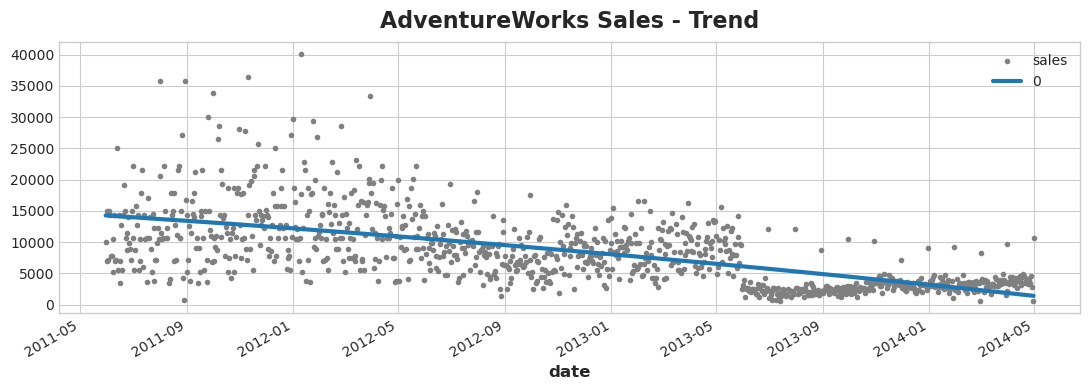

In [29]:
dp = DeterministicProcess(
    index=sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    seasonal = False,    # see seasonality
                        # additional_terms = none, no [fourier], see below seasonality
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
# look at linear trend
y = sales.values
# use linear model to fit trend of sales
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index)
ax = sales.plot(style=".", color="0.5", title="AdventureWorks Sales - Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")


In [30]:
rmsle = sqrt(mean_squared_log_error(y, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 0.57725


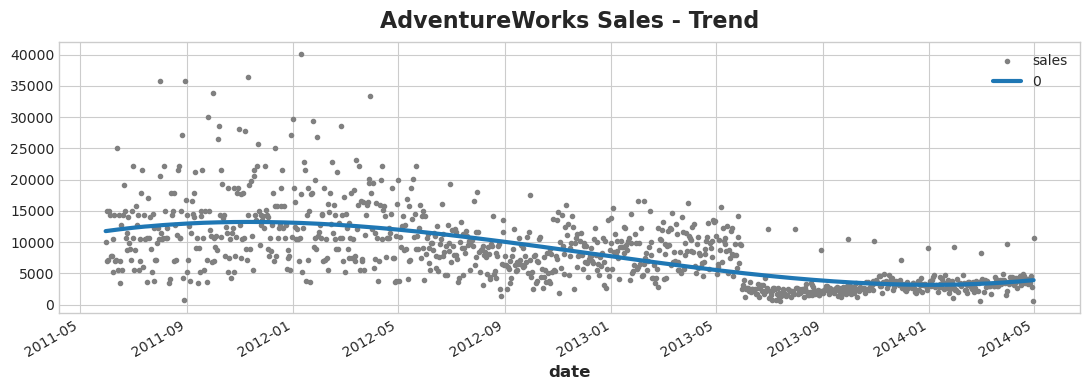

In [31]:
dp = DeterministicProcess(
    index=sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    seasonal = False,    # see seasonality
                        # additional_terms = none, no [fourier], see below seasonality
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
# look at linear trend
y = sales.values
# use linear model to fit trend of sales
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index)
ax = sales.plot(style=".", color="0.5", title="AdventureWorks Sales - Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")


In [32]:
print(model.coef_)

[[ 1.17491509e+04  1.93768988e+01 -6.96882070e-02  4.18883806e-05]]


In [33]:
rmsle = sqrt(mean_squared_log_error(y, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 0.52124


RMSLE: 0.52124 is the lowest error thus far with order = 3, with equation:

y = 11749.1509x1 + 19.3768988x2 - 0.0696882070ex3 +0.0000418883806x4 + 0

Notice that the trend is only captured, which is long-term.  Being able to capture addition components of the time series aides one in accurately predicting sales at a point in time or over a specific date range (the forecast horizon).

# Seasonality

>> We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.  A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. 

Source: Kaggle Time Series Course

<AxesSubplot:title={'center':'Seasonal Plot (year/quarter)'}, xlabel='quarter', ylabel='sales'>

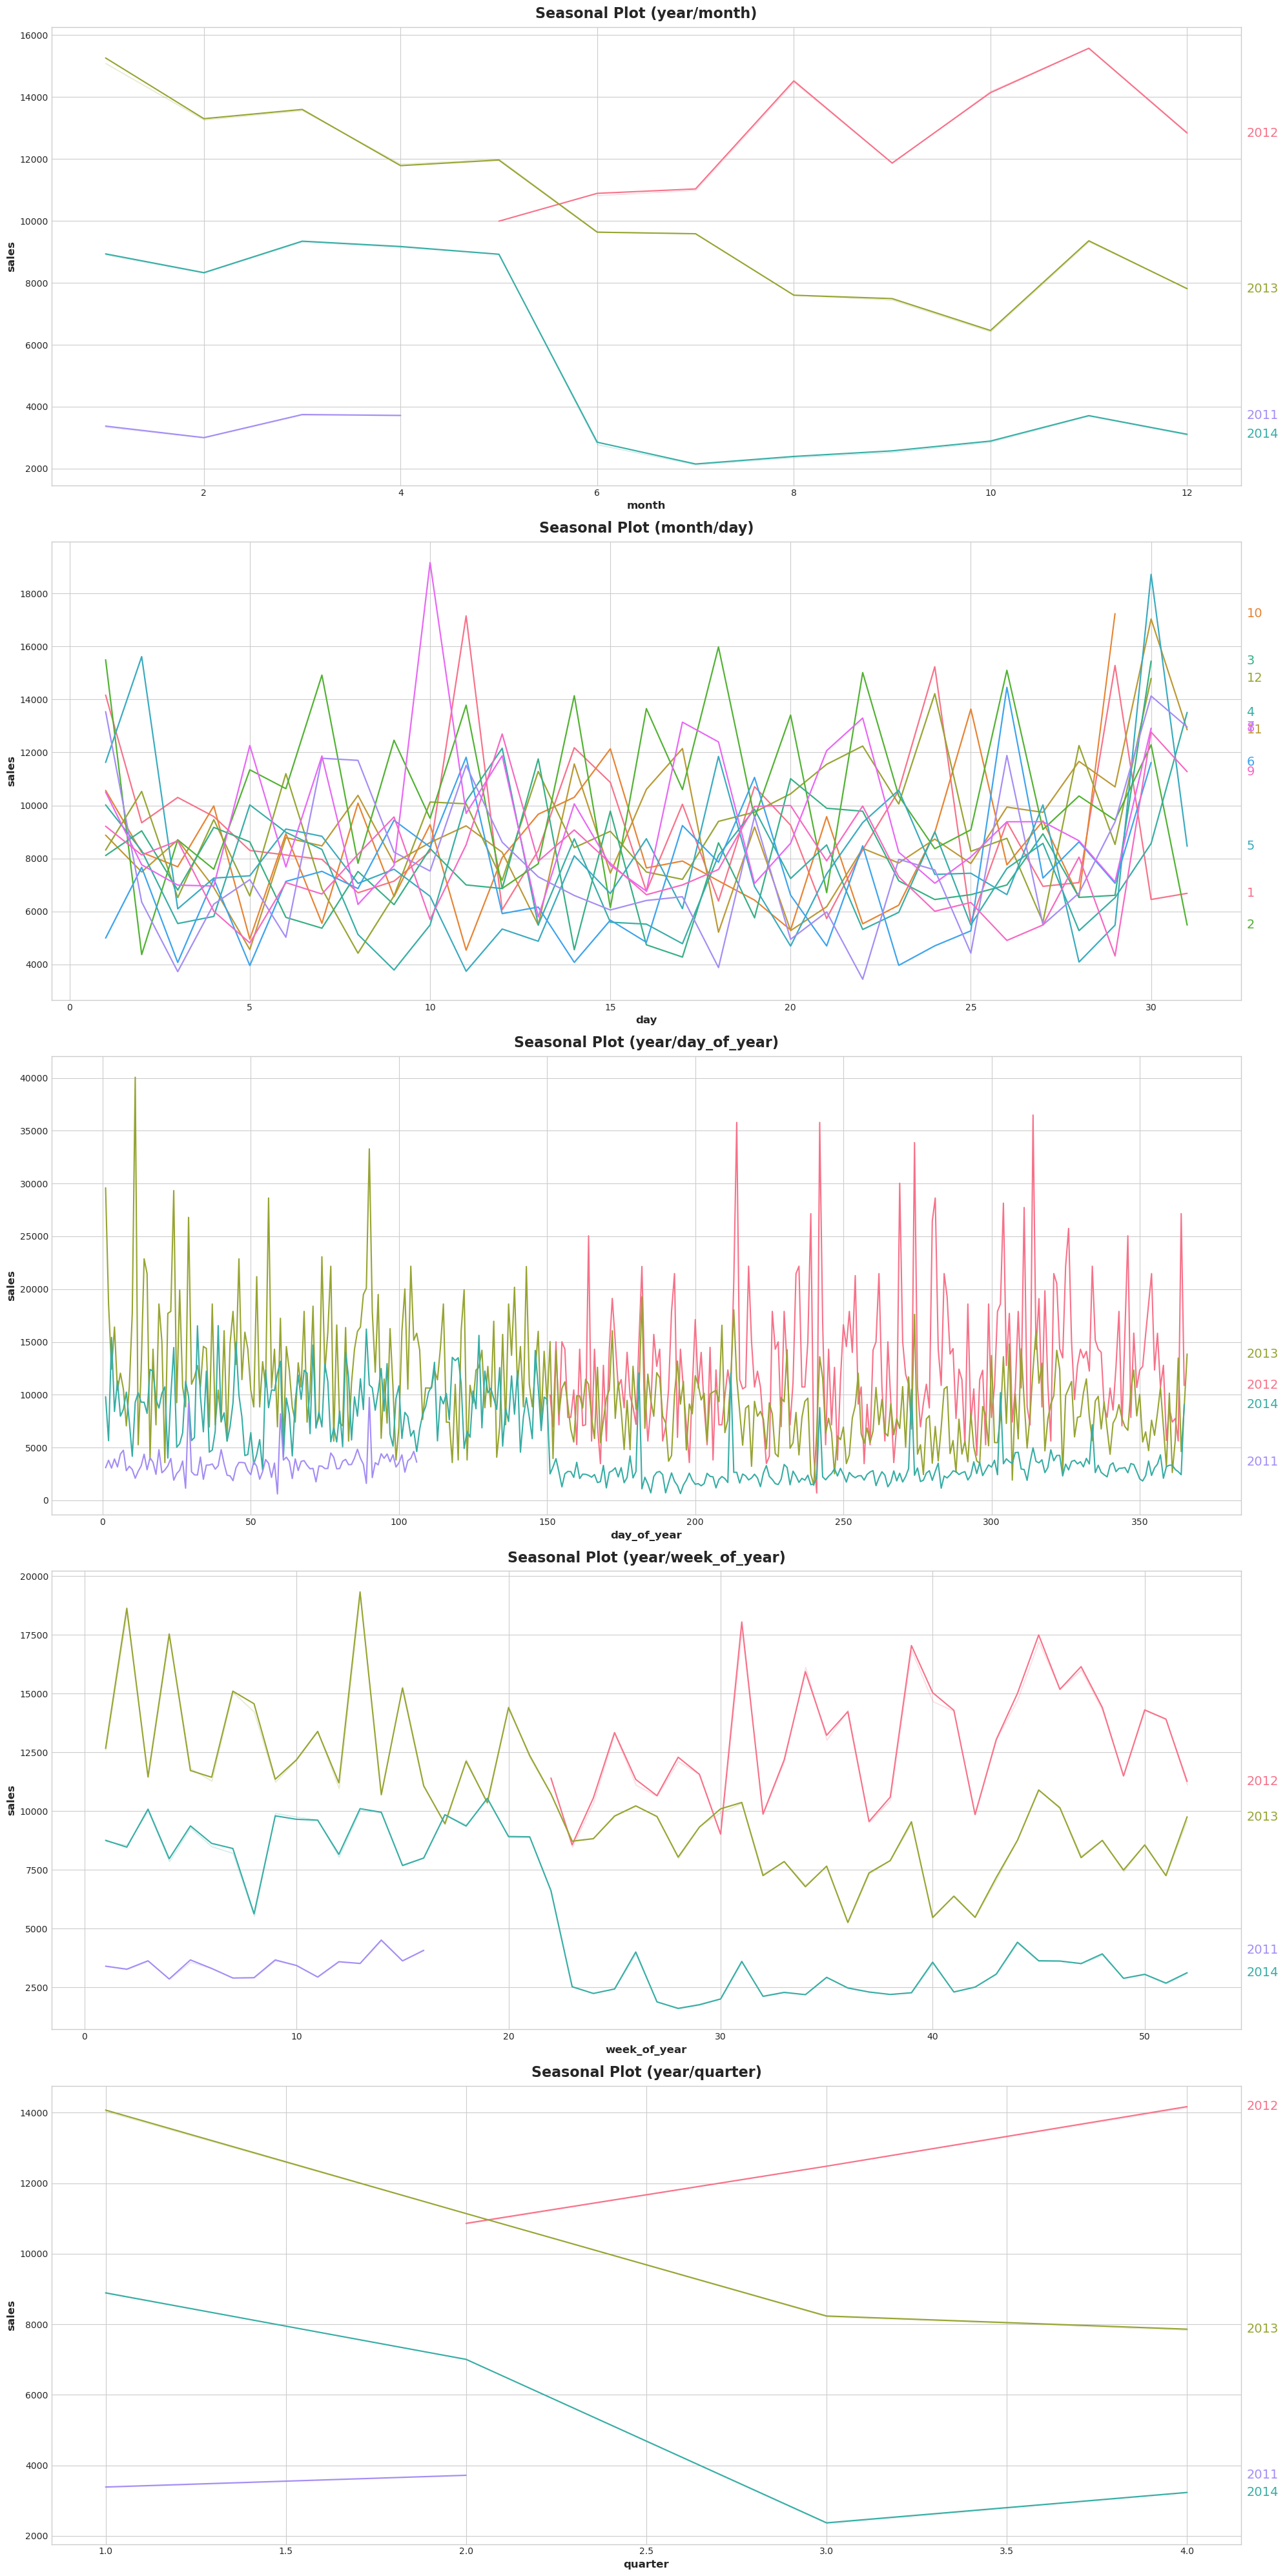

In [34]:
# s = sales by day mean
s = train.groupby("date")['sales'].mean().reset_index()

# create time features
s['year'] = pd.DatetimeIndex(s['date']).year
s['month'] = pd.DatetimeIndex(s['date']).month
s['day'] = pd.DatetimeIndex(s['date']).day
s['day_of_year'] = pd.DatetimeIndex(s['date']).dayofyear
s['week_of_year'] = pd.DatetimeIndex(s['date']).weekofyear
s['quarter'] = pd.DatetimeIndex(s['date']).quarter

# seasonal plots of sales
X = s.copy().set_index('date')
y = s.copy().set_index('date')

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(20, 40))
seasonal_plot(X, y = 'sales', period = 'year', freq = 'month', ax=ax0)
seasonal_plot(X, y = 'sales', period = 'month', freq = 'day', ax=ax1)
seasonal_plot(X, y = 'sales', period = 'year', freq = 'day_of_year', ax=ax2)
seasonal_plot(X, y = 'sales', period = 'year', freq = 'week_of_year', ax=ax3)
seasonal_plot(X, y = 'sales', period = 'year', freq = 'quarter', ax=ax4)

Possible seasonal components include month and quarter in AdventureWorks average sales, thus fourier features for these may reduce residuals, error in model prediction due to capturing of these seasonal components.

>> Fourier features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on...If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series...By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting...How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The periodogram tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, where a and b are the coefficients of the sine and cosine at that frequency.



<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

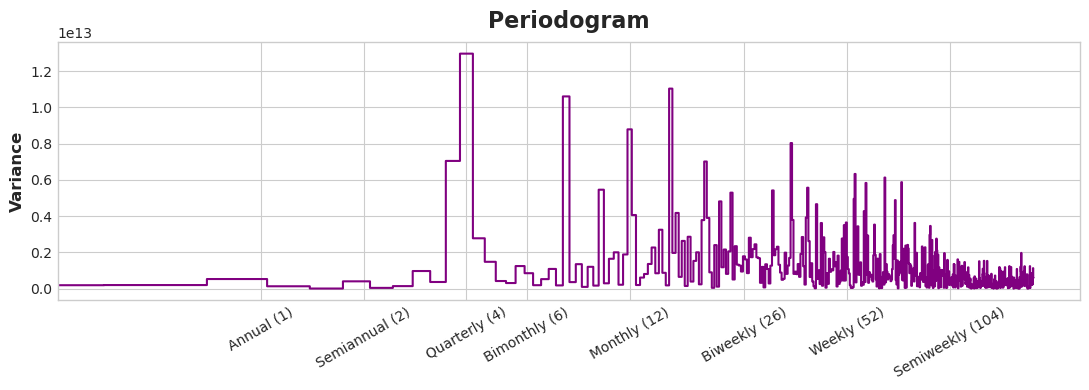

In [35]:
s = train.groupby("date")['sales'].sum().reset_index()
# create periodogram of sales to look at the strength of frequencies in the time series
plot_periodogram(s.sales)

We see that the periodogram shows what the seasonal plots did, there is a quarterly component, monthly component, noise, and perhaps a bimonthly component.  The fall off seems to become noise after 12, monthly, thus we will use 12 fourier pairs.  I will also consider using fewer fourier pairs, as the majority of the seasonality appears to be quarterly, while the bimonthly and monthly peaks may represent cycles.  

# Serial Dependence

>> Some time series properties...can only be modeled as serially dependent properties, that is, using as features past values of the target series. The structure of these time series may not be apparent from a plot over time; plotted against past values, however, the structure becomes clear...One especially common way for serial dependence to manifest is in cycles. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself. Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time. Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior...What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behavior can be much more irregular than seasonality...To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time...The partial autocorrelation tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use. 

Source: Kaggle Time Series Course

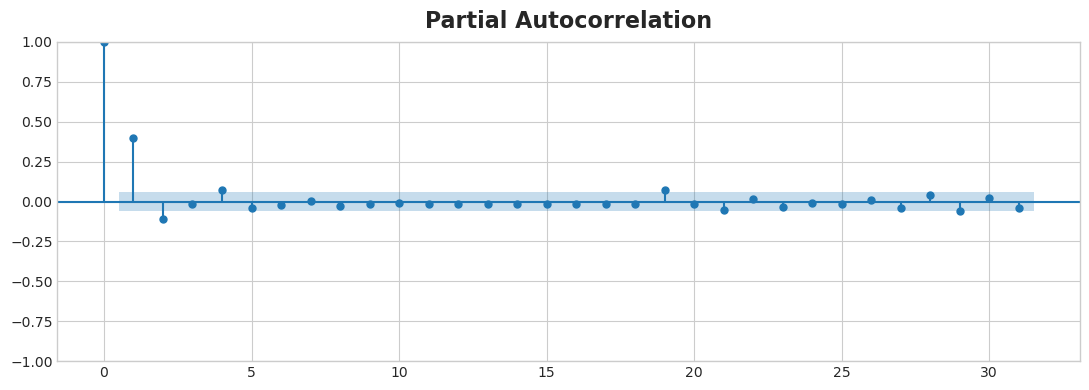

In [36]:
s = train.groupby("date")['sales'].sum().reset_index()
fig = plot_pacf(s.sales)

Partial autocorrelations suggest serial dependence can be captured using lags 1 and 2, possibly 4, 19 seems to be an anomaly.  The shaded blue area represents the 95% confidence interval, lags outside of this interval may be capable of helping to reject a null hypothesis.

# Components Remaining = Error

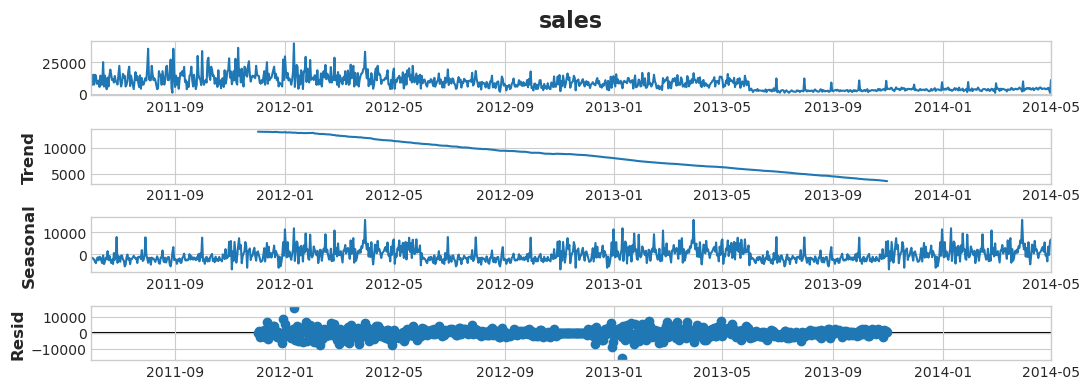

In [37]:
fig = seasonal_decompose(sales['sales'], period=365, model='additive').plot()

Residuals, noise or error, remain once the trend (regression) and seasonal components (using indicators) are captured by the model to some extent.  Let us see if we can reduce residuals by using a trend with order = 3, lags = 2, and 12 fourier pairs.

In [38]:
s = full.copy()
s = s.groupby('date')['sales'].sum().reset_index()
s['date'] = s.date.dt.to_period('D')
s = s.set_index('date')

fourier = CalendarFourier(freq="A", order=12)  # 12 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=s.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend 
    seasonal=True,               # monthly and quarterly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                  
)

X = dp.in_sample()  # create features for dates in s.index

y = s.values

X = make_lags(s.sales, lags=2)
X = X.fillna(0.0)

# use linear model to fit sales components
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = model.predict(X)

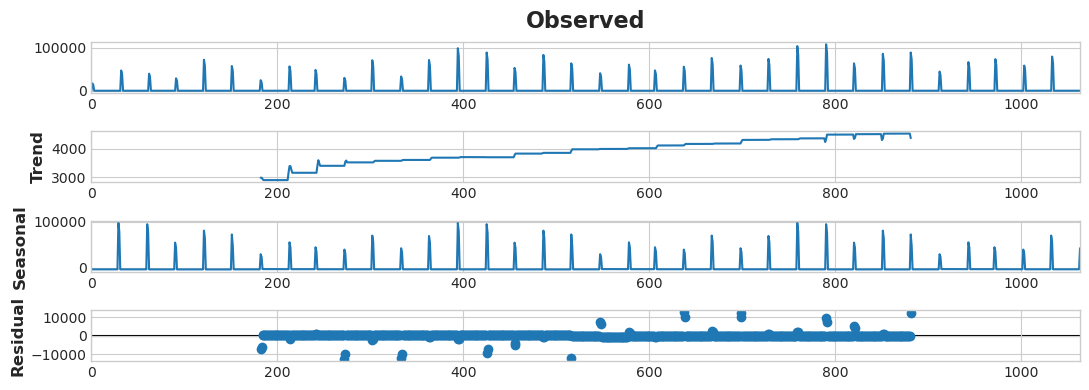

In [39]:
fig = seasonal_decompose(y_pred, period=365, model='additive').plot()

In [40]:
rmsle = sqrt(mean_squared_log_error(y, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 7.17871


Quite a lot of the time series components are captured by a linear regression model alone; let us improve upon this by increasing lags to 4.

In [41]:
fourier = CalendarFourier(freq="A", order=12)  # 12 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=X.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend 
    seasonal=True,               # monthly and quarterly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                  
)

X = dp.in_sample()  # create features for dates in s.index

y = s.values

X = make_lags(s.sales, lags=4)
X = X.fillna(0.0)

# use linear model to fit sales components
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = model.predict(X)

rmsle = sqrt(mean_squared_log_error(y, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 6.40190


Increasing to 4 lags improves modeling.

In [42]:
fourier = CalendarFourier(freq="A", order=4)  # 4 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=s.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend 
    seasonal=True,               # just quarterly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                  
)

X = dp.in_sample()  # create features for dates in s.index

y = s.values

X = make_lags(s.sales, lags=4)
X = X.fillna(0.0)

# use linear model to fit sales components
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = model.predict(X)

rmsle = sqrt(mean_squared_log_error(y, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 6.40190


Decreasing fourier pairs to 4 capturing quarterly seasonality alone with 4 lags decreases number of features without negatively effecting error.  We can capture the shorter term fluctuations in sales with indicators.

In [43]:
s = full.copy()
s = s.groupby('date')['sales'].sum().reset_index()
s['date'] = s.date.dt.to_period('D')
#s['year'] = s['date'].dt.year
s['month'] = s['date'].dt.month
s['quarter'] = s['date'].dt.quarter
s['dayofweek'] = s['date'].dt.dayofweek
s['week'] = s['date'].dt.weekofyear
s['day'] = s['date'].dt.day
s['dayofyear'] = s['date'].dt.dayofyear
s = s.set_index('date')

fourier = CalendarFourier(freq="A", order=4)  # 4 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=X.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend 
    seasonal=True,               # just quarterly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                  
)

X = dp.in_sample()  # create features for dates in s.index

y = s.values

X = make_lags(s.sales, lags=4)
X = X.fillna(0.0)

# use linear model to fit sales components
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = model.predict(X)

rmsle = sqrt(mean_squared_log_error(y, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 3.47975


Using month, quarter, day of year, day of month, day of week, and week of year indicators along with 4 fouriers and 4 lags seems like a good plan; including year does not improve the model.

Eventually we will move past linear regression alone, as the model is best at capturing trend, while other models such as trees, knn, and boosted trees are better at capturing the shorter term fluctuations in sales.

# Multistep Forecasting Strategies

Multioutput model

>> Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.

Direct strategy

>> Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.

Recursive strategy

>> Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.

DirRec strategy

>> A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as new lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

Sources: 
* Kaggle Time Series Course, Machine Learning Strategies for Time Series Forecasting
* Machine Learning Strategies for Time Series Forecasting

#### Multioutput Direct

In [44]:
s = full.copy()
s = s.groupby('date')['sales'].sum().reset_index()
s['date'] = s.date.dt.to_period('D')
#s['year'] = s['date'].dt.year
s['month'] = s['date'].dt.month
s['quarter'] = s['date'].dt.quarter
s['dayofweek'] = s['date'].dt.dayofweek
s['week'] = s['date'].dt.weekofyear
s['day'] = s['date'].dt.day
s['dayofyear'] = s['date'].dt.dayofyear
s = s.set_index('date')

fourier = CalendarFourier(freq="A", order=4)  # 4 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=X.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend 
    seasonal=True,               # just quarterly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                  
)

X = dp.in_sample()  # create features for dates in s.index

y = s.copy()

X = make_lags(s.sales, lags=4)
X = X.fillna(0.0)

y = make_multistep_target(y, steps=15).dropna()

# Shifting has created indexes that don't match
y, X = y.align(X, join='inner', axis=0)

# use linear model to fit sales components
model = LinearRegression(fit_intercept = False)
model.fit(X, y)

y_pred = model.predict(X)

rmsle = sqrt(mean_squared_log_error(y, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 3.48730


Moving forward will will utilize a hydrid model to utilize each models strengths, allowing the models to complement one another.

# Data Processing

Before we build and experiment with hydrid models, we require further processing to enable forecasting of sales by store and product category.

In [45]:
df = full.copy()
print(df.columns)
df.head()

Index(['category', 'date', 'id', 'promo', 'sales', 'storenbr', 'city', 'state',
       'country', 'type', 'cluster', 'search_total', 'transactions',
       'event_type', 'month', 'week', 'quarter', 'day_of_week', 'day_of_year',
       'day'],
      dtype='object')


,category,date,id,promo,sales,storenbr,city,state,country,type,cluster,search_total,transactions,event_type,month,week,quarter,day_of_week,day_of_year,day
0,Caps,2011-05-31,0,0.0,15.56,298,Mansfield,Ohio,United States,BM,Mountain,0.0,52.0,none,5,22,2,1,151,31
1,Caps,2011-05-31,1,0.0,10.37,308,Kansas City,Missouri,United States,OS,Mountain,0.0,35.0,none,5,22,2,1,151,31
2,Caps,2011-05-31,2,0.0,15.56,306,Leesburg,Virginia,United States,BM,Mountain,0.0,52.0,none,5,22,2,1,151,31
3,Caps,2011-05-31,3,0.0,10.37,296,Branch,Minnesota,United States,BM,Road,0.0,35.0,none,5,22,2,1,151,31
4,Caps,2011-05-31,4,0.0,25.93,292,Memphis,Tennessee,United States,BM,Mountain,0.0,65.0,none,5,22,2,1,151,31


In [46]:
# save csv
df.to_csv('full_indicators.csv', index=False)

In [47]:
le = LabelEncoder()

cols = ['city','state','country','type','cluster','event_type']

for feature in cols:
    df[feature] = le.fit_transform(df[feature])
    mapping = dict(zip(le.classes_, range(0, len(le.classes_))))
    print(mapping)

df.head()

{'Abingdon': 0, 'Albany': 1, 'Alexandria': 2, 'Alhambra': 3, 'Alpine': 4, 'Altamonte Springs': 5, 'Arlington': 6, 'Ascheim': 7, 'Atlanta': 8, 'Auburn': 9, 'Augsburg': 10, 'Augusta': 11, 'Aujan Mournede': 12, 'Aurora': 13, 'Austell': 14, 'Austin': 15, 'Bad Soden': 16, 'Baldwin Park': 17, 'Barrie': 18, 'Barstow': 19, 'Basingstoke Hants': 20, 'Baytown': 21, 'Beaverton': 22, 'Bell Gardens': 23, 'Bellevue': 24, 'Bellingham': 25, 'Berks': 26, 'Berkshire': 27, 'Berlin': 28, 'Billings': 29, 'Biloxi': 30, 'Birmingham': 31, 'Bluffton': 32, 'Bobigny': 33, 'Bonn': 34, 'Bothell': 35, 'Boulogne-sur-Mer': 36, 'Bountiful': 37, 'Bracknell': 38, 'Bradenton': 39, 'Braintree': 40, 'Brampton': 41, 'Branch': 42, 'Branson': 43, 'Braunschweig': 44, 'Brossard': 45, 'Burbank': 46, 'Burnaby': 47, 'Byron': 48, 'Calgary': 49, 'Camarillo': 50, 'Cambridge': 51, 'Campbellsville': 52, 'Canoga Park': 53, 'Carol Stream': 54, 'Carrollton': 55, 'Carson': 56, 'Casper': 57, 'Cedar City': 58, 'Cedar Park': 59, 'Central Valle

,category,date,id,promo,sales,storenbr,city,state,country,type,cluster,search_total,transactions,event_type,month,week,quarter,day_of_week,day_of_year,day
0,Caps,2011-05-31,0,0.0,15.56,298,217,41,5,0,0,0.0,52.0,2,5,22,2,1,151,31
1,Caps,2011-05-31,1,0.0,10.37,308,174,31,5,2,0,0.0,35.0,2,5,22,2,1,151,31
2,Caps,2011-05-31,2,0.0,15.56,306,202,61,5,0,0,0.0,52.0,2,5,22,2,1,151,31
3,Caps,2011-05-31,3,0.0,10.37,296,42,29,5,0,1,0.0,35.0,2,5,22,2,1,151,31
4,Caps,2011-05-31,4,0.0,25.93,292,226,55,5,0,0,0.0,65.0,2,5,22,2,1,151,31


In [48]:
df['date'] = df.date.dt.to_period('D')
df = df.set_index(['date','storenbr','category']).sort_index()
df.head(10)

id  promo     sales  city  state  \
date       storenbr category                                              
2011-05-31 1        Mountain Bikes   1366    0.0  10199.97   183     55   
                    Road Bikes       1973    0.0   4277.37   183     55   
           292      Caps                4    0.0     25.93   226     55   
                    Helmets           467    0.0    322.98   226     55   
                    Jerseys           963    0.0    547.97   226     55   
                    Mountain Bikes   1441    0.0  77159.77   226     55   
                    Mountain Frames  1841    0.0   2882.49   226     55   
                    Road Bikes       2113    0.0  21800.83   226     55   
                    Road Frames      2476    0.0   1633.75   226     55   
                    Socks            2972    0.0     45.60   226     55   

                                     country  type  cluster  search_total  \
date       storenbr category                                                
2011-05-31 1        Mountain Bikes         5     0        0           0.0   
                    Road Bikes             5     0        0           0.0   
           292      Caps                   5     0        0           0.0   
                    Helmets                5     0        0           0.0   
                    Jerseys                5     0        0           0.0   
                    Mountain Bikes         5     0        0           0.0   
                    Mountain Frames        5     0        0           0.0   
                    Road Bikes             5     0        0           0.0   
                    Road Frames            5     0        0           0.0   
                    Socks                  5     0        0           0.0   

                                     transactions  event_type  month  week  \
date       storenbr category                                                 
2011-05-31 1        Mountain Bikes            5.0           2      5    22   
                    Road Bikes                5.0           2      5    22   
           292      Caps                     65.0           2      5    22   
                    Helmets                  65.0           2      5    22   
                    Jerseys                  65.0           2      5    22   
                    Mountain Bikes           65.0           2      5    22   
                    Mountain Frames          65.0           2      5    22   
                    Road Bikes               65.0           2      5    22   
                    Road Frames              65.0           2      5    22   
                    Socks                    65.0           2      5    22   

                                     quarter  day_of_week  day_of_year  day  
date       storenbr category                                                 
2011-05-31 1        Mountain Bikes         2            1          151   31  
                    Road Bikes             2            1          151   31  
           292      Caps                   2            1          151   31  
                    Helmets                2            1          151   31  
                    Jerseys                2            1          151   31  
                    Mountain Bikes         2            1          151   31  
                    Mountain Frames        2            1          151   31  
                    Road Bikes             2            1          151   31  
                    Road Frames            2            1          151   31  
                    Socks                  2            1          151   31

In [49]:
df_temp = make_lags(df['sales'], lags=4)
df_temp = df_temp.fillna(0.0)

In [50]:
df_temp.head()

y_lag_1   y_lag_2   y_lag_3   y_lag_4
date       storenbr category                                              
2011-05-31 1        Mountain Bikes      0.00      0.00      0.00      0.00
                    Road Bikes      10199.97      0.00      0.00      0.00
           292      Caps             4277.37  10199.97      0.00      0.00
                    Helmets            25.93   4277.37  10199.97      0.00
                    Jerseys           322.98     25.93   4277.37  10199.97

In [51]:
df_features = df.merge(df_temp, left_index=True, right_index=True, how = 'left')

In [52]:
df_features

id  promo     sales  city  state  \
date       storenbr category                                                
2011-05-31 1        Mountain Bikes     1366   0.00  10199.97   183     55   
                    Road Bikes         1973   0.00   4277.37   183     55   
           292      Caps                  4   0.00     25.93   226     55   
                    Helmets             467   0.00    322.98   226     55   
                    Jerseys             963   0.00    547.97   226     55   
...                                     ...    ...       ...   ...    ...   
2014-05-01 2051     Socks            346643   0.00    113.27    92     37   
                    Tires and Tubes  347110   0.00     10.99    92     37   
                    Touring Bikes    347812   0.00  50945.08    92     37   
                    Touring Frames   348514   0.00  11033.52    92     37   
                    Vests            349216   0.05   1402.24    92     37   

                                     country  type  cluster  search_total  \
date       storenbr category                                                
2011-05-31 1        Mountain Bikes         5     0        0           0.0   
                    Road Bikes             5     0        0           0.0   
           292      Caps                   5     0        0           0.0   
                    Helmets                5     0        0           0.0   
                    Jerseys                5     0        0           0.0   
...                                      ...   ...      ...           ...   
2014-05-01 2051     Socks                  5     0        2           0.0   
                    Tires and Tubes        5     0        2           0.0   
                    Touring Bikes          5     0        2           0.0   
                    Touring Frames         5     0        2           0.0   
                    Vests                  5     0        2           0.0   

                                     transactions  ...  month  week  quarter  \
date       storenbr category                       ...                         
2011-05-31 1        Mountain Bikes            5.0  ...      5    22        2   
                    Road Bikes                5.0  ...      5    22        2   
           292      Caps                     65.0  ...      5    22        2   
                    Helmets                  65.0  ...      5    22        2   
                    Jerseys                  65.0  ...      5    22        2   
...                                           ...  ...    ...   ...      ...   
2014-05-01 2051     Socks                     1.0  ...      5    18        2   
                    Tires and Tubes           1.0  ...      5    18        2   
                    Touring Bikes             1.0  ...      5    18        2   
                    Touring Frames            1.0  ...      5    18        2   
                    Vests                     1.0  ...      5    18        2   

                                     day_of_week  day_of_year  day   y_lag_1  \
date       storenbr category                                                   
2011-05-31 1        Mountain Bikes             1          151   31      0.00   
                    Road Bikes                 1          151   31  10199.97   
           292      Caps                       1          151   31   4277.37   
                    Helmets                    1          151   31     25.93   
                    Jerseys                    1          151   31    322.98   
...                                          ...          ...  ...       ...   
2014-05-01 2051     Socks                      3          121    1   4025.01   
                    Tires and Tubes            3          121    1    113.27   
                    Touring Bikes              3          121    1     10.99   
                    Touring Frames             3          121    1  50945.08   
                    Vests           

In [54]:
fourier = CalendarFourier(freq="A", order=4)  # 4 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=X.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend 
    seasonal=True,               # just quarterly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                  
)

dp_df = dp.in_sample()  

In [55]:
df_features = df_features.merge(dp_df, left_index=True, right_index=True, how = 'left')

In [56]:
df_features.head()

id  promo     sales  city  state  \
date       storenbr category                                             
2011-05-31 1        Mountain Bikes  1366    0.0  10199.97   183     55   
                    Road Bikes      1973    0.0   4277.37   183     55   
           292      Caps               4    0.0     25.93   226     55   
                    Helmets          467    0.0    322.98   226     55   
                    Jerseys          963    0.0    547.97   226     55   

                                    country  type  cluster  search_total  \
date       storenbr category                                               
2011-05-31 1        Mountain Bikes        5     0        0           0.0   
                    Road Bikes            5     0        0           0.0   
           292      Caps                  5     0        0           0.0   
                    Helmets               5     0        0           0.0   
                    Jerseys               5     0        0           0.0   

                                    transactions  ...  s(6,7)  s(7,7)  \
date       storenbr category                      ...                   
2011-05-31 1        Mountain Bikes           5.0  ...     0.0     0.0   
                    Road Bikes               5.0  ...     0.0     0.0   
           292      Caps                    65.0  ...     0.0     0.0   
                    Helmets                 65.0  ...     0.0     0.0   
                    Jerseys                 65.0  ...     0.0     0.0   

                                    sin(1,freq=A-DEC)  cos(1,freq=A-DEC)  \
date       storenbr category                                               
2011-05-31 1        Mountain Bikes            0.53073          -0.847541   
                    Road Bikes                0.53073          -0.847541   
           292      Caps                      0.53073          -0.847541   
                    Helmets                   0.53073          -0.847541   
                    Jerseys                   0.53073          -0.847541   

                                    sin(2,freq=A-DEC)  cos(2,freq=A-DEC)  \
date       storenbr category                                               
2011-05-31 1        Mountain Bikes          -0.899631           0.436651   
                    Road Bikes              -0.899631           0.436651   
           292      Caps                    -0.899631           0.436651   
                    Helmets                 -0.899631           0.436651   
                    Jerseys                 -0.899631           0.436651   

                                    sin(3,freq=A-DEC)  cos(3,freq=A-DEC)  \
date       storenbr category                                               
2011-05-31 1        Mountain Bikes           0.994218           0.107381   
                    Road Bikes               0.994218           0.107381   
           292      Caps                     0.994218           0.107381   
                    Helmets                  0.994218           0.107381   
                    Jerseys                  0.994218           0.107381   

                                    sin(4,freq=A-DEC)  cos(4,freq=A-DEC)  
date       storenbr category                                              
2011-05-31 1        Mountain Bikes           -0.78565          -0.618671  
                    Road Bikes               -0.78565          -0.618671  
           292      Caps                     -0.78565          -0.618671  
                    Helmets                  -0.78565          -0.618671  
                    Jerseys                  -0.78565          -0.618671  

[5 rows x 39 columns]

In [ ]:
# save df with added features: lags indicators, fourier pairs
df_features.to_csv('df_features.csv', index=False)

In [57]:
y = df_features['sales']

In [58]:
df_features = df_features.drop('sales', axis = 1)

In [59]:
# split into testing and training data
df_train = df_features.loc[:'2014-04-16',:]
df_test = df_features.loc['2014-04-17':,:]
y_train, y_test = y[:'2014-04-16'], y['2014-04-17':]
X1_train, X1_test = df_train, df_test
X2_train, X2_test = df_train, df_test

X1_test = X1_test.fillna(method = 'ffill')
X2_test = X2_test.fillna(method = 'ffill')

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# Build a Boosted Hybrid Model and Make Predications

In [60]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [61]:
# create a boosted hybrid minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None

In [62]:
# more helper functions to fit and predict
def fit(self, X1_train, X2_train, y):
    # Fit self.model_1
    self.model_1.fit(X1_train, y_train)

    # Make predictions with self.model_1
    y_fit = pd.DataFrame(
        self.model_1.predict(X1_train), 
        index=X1_train.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X2_train, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

In [63]:
def predict(self, X1_train, X2_train):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X1_train), 
        index=X1_train.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X2_train)

    #return y_pred.unstack(['date', 'storenbr', 'category'])
    return y_pred


# Add method to class
BoostedHybrid.predict = predict

### Prediction One

We will look at various combinations of models to see how effectively they work with one another to capture trend (regression type model) and everything else (tree type model).

First we will use the same model 2, XGBoost with various model 1's to select a regression model.

Note: we are not evaluating a forecast, just how well they learn

In [64]:
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(random_state=0),
)

model.fit(X1_train, X2_train, y_train)

y_pred = model.predict(X1_train, X2_train)
y_pred = y_pred.clip(0.0)

rmsle = sqrt(mean_squared_log_error(y_train, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 3.53316


In [65]:
model = BoostedHybrid(
    model_1=Lasso(random_state=0),
    model_2=XGBRegressor(random_state=0),
)

model.fit(X1_train, X2_train, y_train)

y_pred = model.predict(X1_train, X2_train)
y_pred = y_pred.clip(0.0)

rmsle = sqrt(mean_squared_log_error(y_train, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 3.47286


In [66]:
model = BoostedHybrid(
    model_1=ElasticNet(random_state=0),
    model_2=XGBRegressor(random_state=0),
)

model.fit(X1_train, X2_train, y_train)

y_pred = model.predict(X1_train, X2_train)
y_pred = y_pred.clip(0.0)

rmsle = sqrt(mean_squared_log_error(y_train, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 3.50178


Of model_1 experiments, Lasso performed the best.  Now we will experiment with different model_2's

In [67]:
model = BoostedHybrid(
    model_1=Lasso(random_state=0),
    model_2=ExtraTreesRegressor(random_state=0),
)

model.fit(X1_train, X2_train, y_train)

y_pred = model.predict(X1_train, X2_train)
y_pred = y_pred.clip(0.0)

rmsle = sqrt(mean_squared_log_error(y_train, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 0.00000


In [68]:
model = BoostedHybrid(
    model_1=Lasso(random_state=0),
    model_2=RandomForestRegressor(random_state=0),
)

model.fit(X1_train, X2_train, y_train)

y_pred = model.predict(X1_train, X2_train)
y_pred = y_pred.clip(0.0)

rmsle = sqrt(mean_squared_log_error(y_train, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 0.94767


In [69]:
model = BoostedHybrid(
    model_1=Lasso(random_state=0),
    model_2=KNeighborsRegressor(),
)

model.fit(X1_train, X2_train, y_train)

y_pred = model.predict(X1_train, X2_train)
y_pred = y_pred.clip(0.0)

rmsle = sqrt(mean_squared_log_error(y_train, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 1.87554


In [70]:
model = BoostedHybrid(
    model_1=Lasso(random_state=0),
    model_2=MLPRegressor(random_state=0),
)

model.fit(X1_train, X2_train, y_train)

y_pred = model.predict(X1_train, X2_train)
y_pred = y_pred.clip(0.0)

rmsle = sqrt(mean_squared_log_error(y_train, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 6.61692


Lasso with ExtraTrees obtained the lowest RMSLE.  ElasticNet is very similar to lasso, let us check ElasticNet with ExtraTrees.

In [71]:
# for good measure ElasticNet with selected model 2
model = BoostedHybrid(
    model_1=ElasticNet(random_state=0),
    model_2=ExtraTreesRegressor(random_state=0),
)

model.fit(X1_train, X2_train, y_train)

y_pred = model.predict(X1_train, X2_train)
y_pred = y_pred.clip(0.0)

rmsle = sqrt(mean_squared_log_error(y_train, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 0.00000


[Lasso regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

class sklearn.linear_model.Lasso(alpha=1.0, \*, fit_intercept=True, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

* Linear Model trained with L1 prior as regularizer (aka the Lasso).
* The optimization objective for Lasso is: 
 - (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
* Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).  
* The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. For this reason, Lasso and its variants are fundamental to the field of compressed sensing. Under certain conditions, it can recover the exact set of non-zero coefficients (see Compressive sensing: tomography reconstruction with L1 prior (Lasso). The lasso estimate thus solves the minimization of the least-squares penalty with alpha * ||w||_1 added, where alpha is a constant and ||w||_1 is the  L1-norm of the coefficient vector.

[ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet.fit)

class sklearn.linear_model.ElasticNet(alpha=1.0, \*, l1_ratio=0.5, fit_intercept=True, precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

* Linear regression with combined L1 and L2 priors as regularizer.
* Minimizes the objective function: 
 - 1 / (2 * n_samples) * ||y - Xw||^2_2
 - (+ alpha * l1_ratio * ||w||_1)
 - (+ 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2)
* ElasticNet is a linear regression model trained with both L1 and L2-norm regularization of the coefficients. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameter.  
* Elastic-net is useful when there are multiple features that are correlated with one another. 
 - Lasso is likely to pick one of these at random, while 
 - elastic-net is likely to pick both.  
* A practical advantage of trading-off between Lasso and Ridge is that it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

[ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)

class sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, \*, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

* An extra-trees regressor.
* This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
* In extremely randomized trees (see ExtraTreesClassifier and ExtraTreesRegressor classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

Sparse 

Sparse features and solutions refer to data having mostly zero values.  

### Model Choice Considerations

Sparsity occurs in our sales data as several stores do not make sales daily or may make no sales of a specific product on a daily basis.  Additionally, we have encoded data and Fourier features that introduce many sparse features and values.

Other considerations include relationships between features, as there are many features derived from the time series index they are highly correlated with one another.

Although our data is not high dimensional, when features out number observations, we do have a considerable number of independent variables at or near zero; thus, either the lasso or elasticnet model would be advantageous choices in capturing the time series trend.  

With the addition consideration of correlation between these variables, elasticnet provides the added benefit of not choosing these variables randomly, as lasso does.

### model = BoostedHybrid(
###    model_1=ElasticNet(random_state=0),
###    model_2=ExtraTreesRegressor(random_state=0),
### )

### Evaluation: Test Data

In [73]:
y_pred = model.predict(X1_test, X2_test)
y_pred = y_pred.clip(0.0)

rmsle = sqrt(mean_squared_log_error(y_test, y_pred))
print(f'RMSLE: {rmsle:.5f}')

RMSLE: 3.45790


# Results

In [78]:
test = y_test.copy()
pred = y_pred.copy()
test = test.reset_index()
pred = pred.reset_index()
df_results = test.merge(pred, how="left", on=['date','storenbr','category'])
df_results = df_results.rename(columns={0:'predictions'})
df_results = df_results.drop('level_3', axis = 1)
df_results['date'] = df_results['date'].astype(str)
df_results['date'] = pd.to_datetime(df_results['date'])

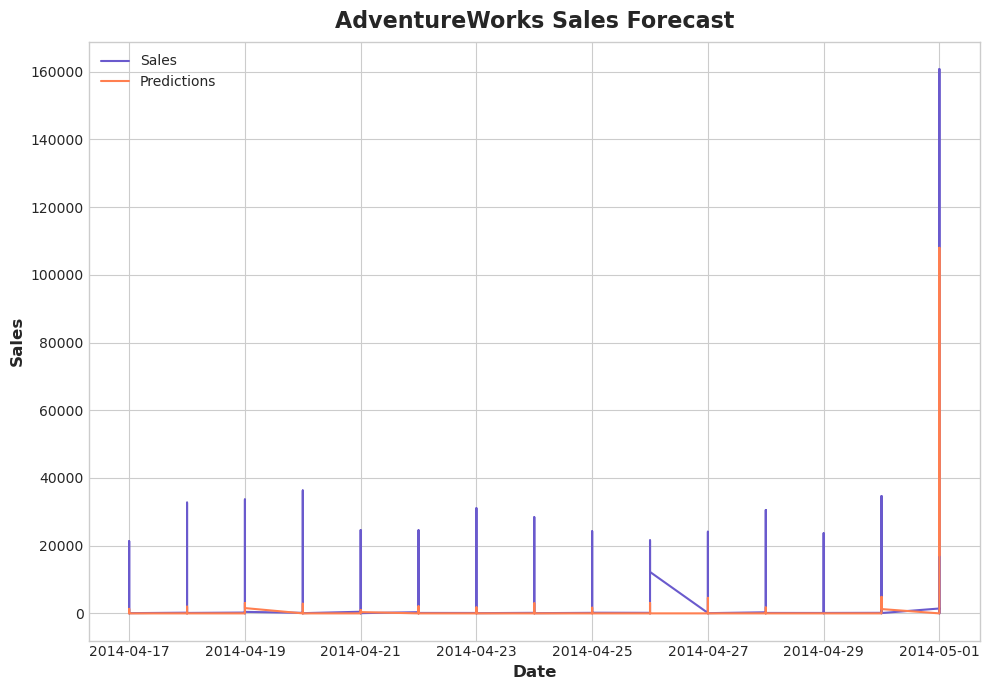

In [87]:
plt.figure(figsize=(10, 7))
plt.plot(df_results['date'], df_results['sales'], 'slateblue', label = 'Sales')
plt.plot(df_results['date'], df_results['predictions'], 'coral', label = 'Predictions')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('AdventureWorks Sales Forecast');

Importantly the model seems to have captured sales spikes that occur in cycles, not always at the beginning or end of the month.  The model seems to capture the pattern but not the amplitude of sales.

For further inspection see related notebooks...